# Fitting spin waves using SpinW
SpinW is a Matlab library that numerically solves any bilinear spin Hamiltonian. Details can be found on the website: https://spinw.org/

We will here show how SpinW can be used to fit the data we have been working with. We will first set up a SpinW model, then repeat the analysis from the previous notebook. We first import pace as usual.


In [1]:
from pace_neutrons import Matlab
m = Matlab()
import numpy as np


Interface opened
All features have moved to hor_config
> In herbert_config (line 3)Warning: Cannot find test path, possible failed setup
!==================================================================!
!          ISIS utilities for visualization and analysis           !
!                   of neutron spectroscopy data                   !
!                          Herbert 4.0.0                           !
!------------------------------------------------------------------!
All features have moved to hor_config
!==================================================================!
!                           Horace 4.0.0                           !
!------------------------------------------------------------------!
!   Visualisation of multi-dimensional neutron spectroscopy data   !
!           R.A. Ewings, A. Buts, M.D. Le, J van Duijn,            !
!                  I. Bustinduy, and T.G. Perring                  !
!                                                                 

We set up a SpinW model that matches the model we used in the previous tutorial. Note that it's simple to set up models that are way more complicated. For example, the space group symmetries can be included in the `genlattice` method, different magnetic atoms can be included, and an arbitrary number of exchange couplings and anisotropies. We refer to the SpinW tutorials for these.

Note that plotting the magnetic structure works best in windowed mode, so that the structure can be inspected. 

In [2]:

%matlab_plot_mode windowed
fm_spinw_model = m.spinw();
a = 2.87
fm_spinw_model.genlattice('lat_const', [a, a, a], 'angled', [90, 90, 90]) 
fm_spinw_model.addatom('label', 'MFe3', 'r', [0, 0, 0], 'S', 5/2, 'color', 'gold') # add iron atom
fm_spinw_model.gencoupling() # generate coupling table
fm_spinw_model.addmatrix('label', 'J1', 'value', 1, 'color', 'gray') # Create a near neighbor coupling matrix with J1 = 1 meV
fm_spinw_model.addmatrix('label', 'D', 'value', m.diag([0, 0, -1]), 'color', 'green') # Create a single-ion anisotropy matrix with D = diag(0, 0, -1) meV
fm_spinw_model.addcoupling('mat', 'J1', 'bond', 1) # Asign the J1 matrix to the first bond
fm_spinw_model.addaniso('D') # Assign the D matrix to the anisotropy term
# fe.genmagstr('mode', 'direct', 'S', np.array([[0., 0., 1.], [0., 0., 1.]]).T);  # generate the magnetic structure
fm_spinw_model.genmagstr('mode', 'direct', 'S', np.array([[0., 0., 1.]]).T);  # generate the magnetic structure

hf2 = m.plot(fm_spinw_model, 'range', [2, 2, 2]) # plot the structure

Creating the bond list (maxDistance = 8 Å, nCell = 3x3x3)...
...40 bonds are retained out of 196 generated!
Creating 3D plot... 
...14k faces and 9k vertices are drawn!


Now that we have set up a model, we can repeat the analysis from before. We make the same cuts as in the previous tutorial, and define the linear background

In [3]:

sqw_file = 'demo.sqw'
proj = {'u':[1,0,0], 'v':[0,1,0], 'type':'rrr'}
energy_range = range(20, 160, 20)
my_cuts = []

for i in range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.025,3], [-1.1,-0.9], [-0.1,0.1], [-10+energy_range[i], 10+energy_range[i]]))

energy_range = range(160, 320, 40)
for i in range(len(energy_range)):
    my_cuts.append(m.cut_sqw(sqw_file, proj, [-3,0.05,3], [-2.1,-1.9], [-0.1,0.1], [-20+energy_range[i], 20+energy_range[i]]))

    
def linear_bg(x,p):
    """
    Linear background function for fitting.

    Parameters
    ----------
    x : array-like
        Independent variable (e.g., energy transfer).
    p : list or array-like
        Model parameters:
        p[0] = slope (m)
        p[1] = intercept (b)

    Returns
    -------
    y : array-like
        The linear background value at each x.
    """
    return p[0] * x + p[1]

*** Step 1 of 1; Read data for     9632 pixels -- processing data... ----->  retained      3478 pixels
*** Step 1 of 1; Read data for    10308 pixels -- processing data... ----->  retained      2518 pixels
*** Step 1 of 1; Read data for    11131 pixels -- processing data... ----->  retained      4165 pixels
*** Step 1 of 1; Read data for    12133 pixels -- processing data...*** Step 1 of 1; Read data for    21316 pixels -- processing data... ----->  retained      5163 pixels
*** Step 1 of 1; Read data for    21183 pixels -- processing data... ----->  retained      3881 pixels
*** Step 1 of 1; Read data for    22083 pixels -- processing data... ----->  retained      6753 pixels
*** Step 1 of 1; Read data for    21348 pixels -- processing data... ----->  retained      6996 pixels
*** Step 1 of 1; Read data for    17913 pixels -- processing data... ----->  retained      8145 pixels
*** Step 1 of 1; Read data for    32768 pixels -- processing data... ----->  retained     11042 pixels
*** S

Setting up the fit works almost the same as before, except more settings are required when setting the fit function. For simplicity, we write those settings separately. The first set of inputs are `'mat'` and then a list of the names of the matrices corresponding to the couplings we want to fit - in this case `J` and `D`. To indicate that we only defined the last element of the diagonal of `D` we give its indices as well, `D(3,3)`. We furthermore disable an automatic check of whether the Hamiltonian is Hermittian (`'hermit', False`), optimize memory (`'optmem', 1,`) and speed (`'useFast', True`). We choose a damped harmonic osccilator as the resolution  (`'resfun', 'sho'`), and include the magnetic form factor  (`'formfact', True`). Note that SpinW knows the magnetic form factor of all magnetic atoms, so the user does not need to specify it. 

The fit takes about a minute.

In [4]:
# Constant parameters for SpinW model
# Note that we use the damped harmonic oscillator resolution model ('sho')
cpars = ['mat', ['J1', 'D(3,3)'], 'hermit', False, 'optmem', 1,
         'useFast', True, 'resfun', 'sho', 'formfact', True]

# Initial parameters:

J = 35
D_A = 0
gam = 30
temp = 10
amp = 300

kk = m.multifit_sqw (*my_cuts)
kk = kk.set_fun(fm_spinw_model.horace_sqw, ([J, D_A, gam, temp, amp], *cpars))

kk = kk.set_free ([1, 0, 1, 0, 1])
kk = kk.set_bfun (linear_bg, [0.0,0.6])
kk = kk.set_bfree ([0,1])
kk = kk.set_options ('list',2)

wfit, fitdata = kk.fit('comp');


--------------------------------------------------------------------------------Beginning fit (max 20 iterations)Calculating COMMENSURATE spin wave spectra (nMagExt = 1, nHkl = 3478, nTwin = 1)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
Calculating COMMENSURATE spin wave spectra (nMagExt = 1, nHkl = 2518, nTwin = 1)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
Calculating COMMENSURATE spin wave spectra (nMagExt = 1, nHkl = 4165, nTwin = 1)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
Calculating COMMENSURATE spin wave spectra (nMagExt = 1, nHkl = 3083, nTwin = 1)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor i

Let us inspect the fit like before

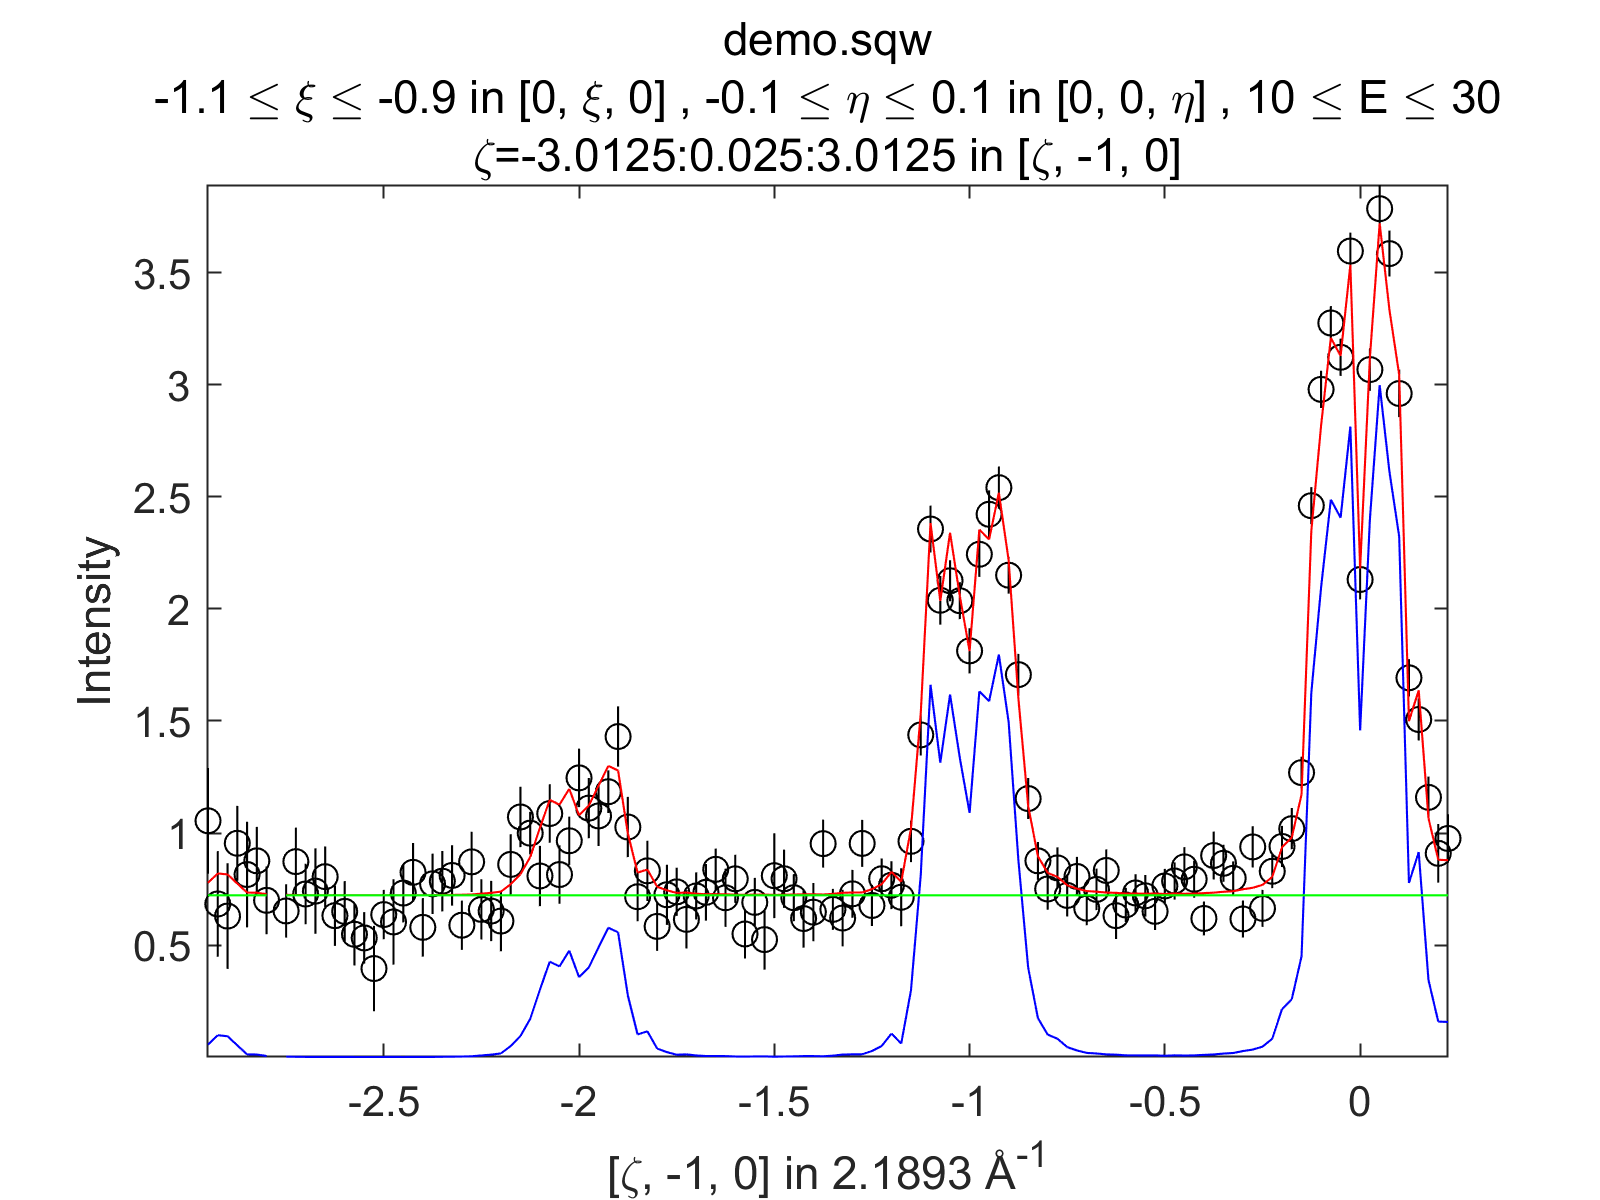

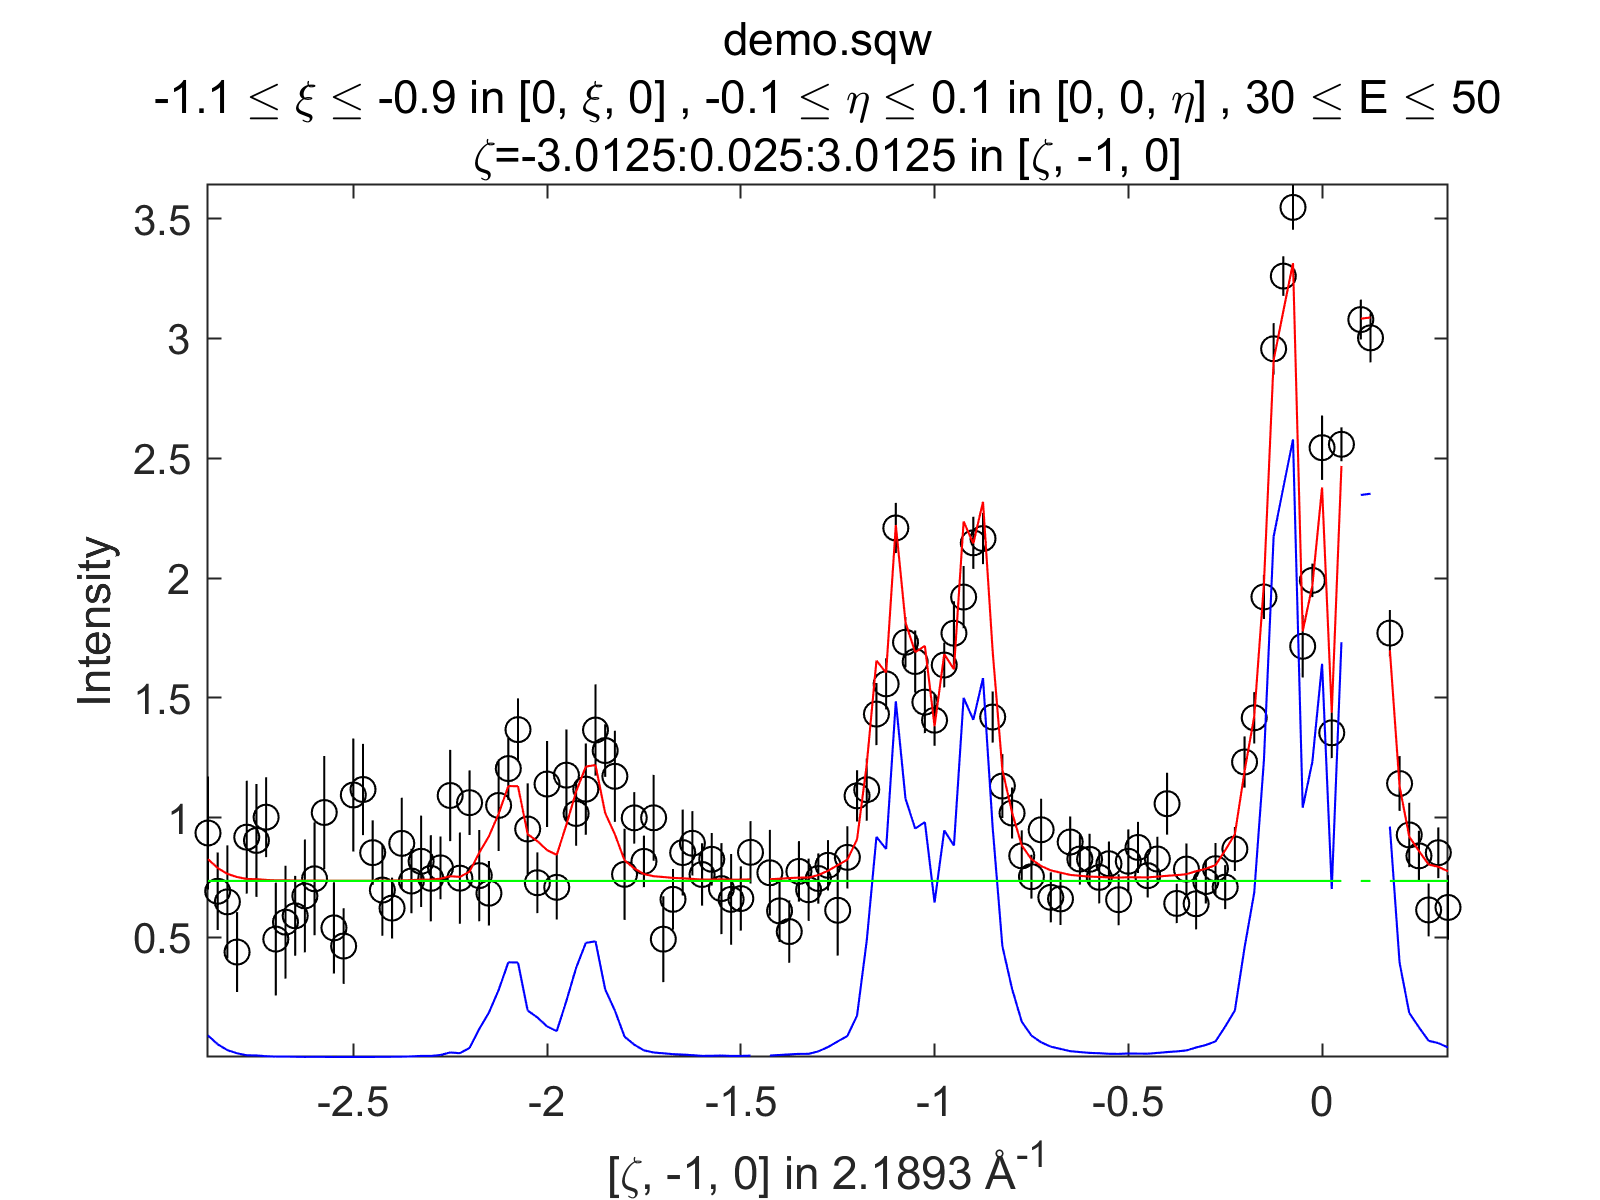

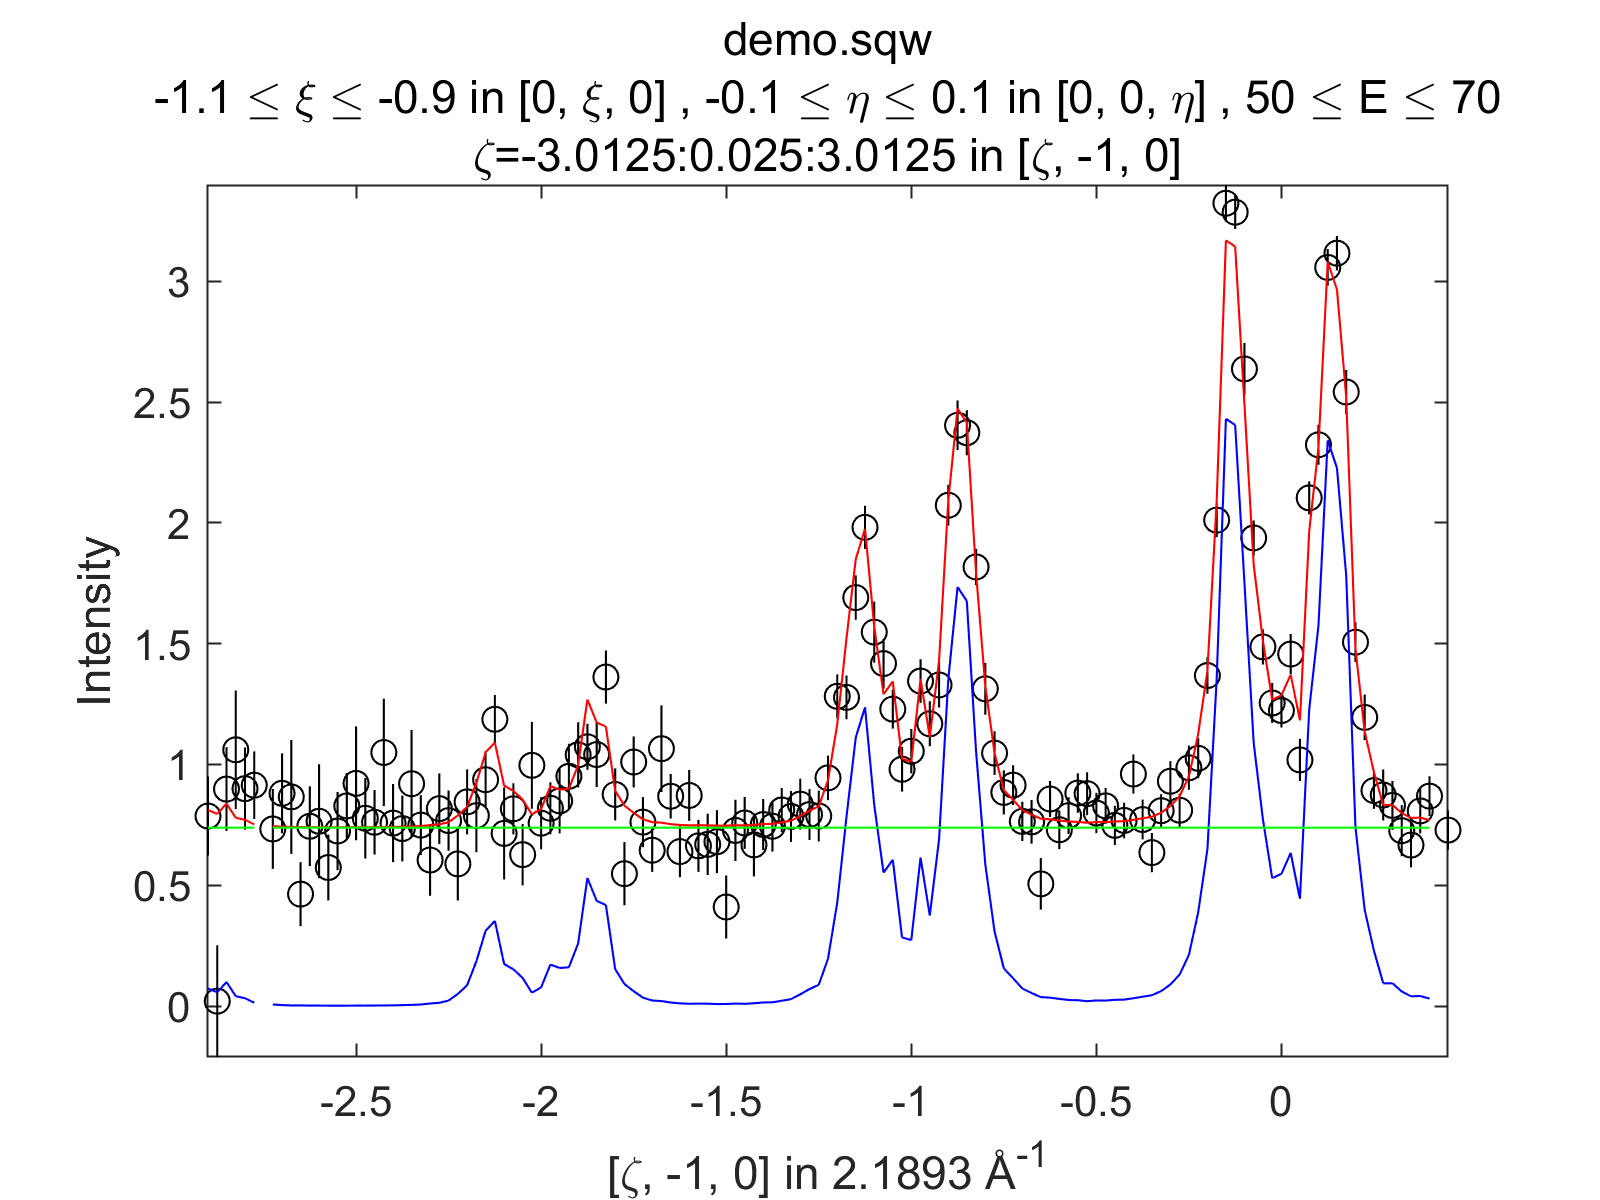

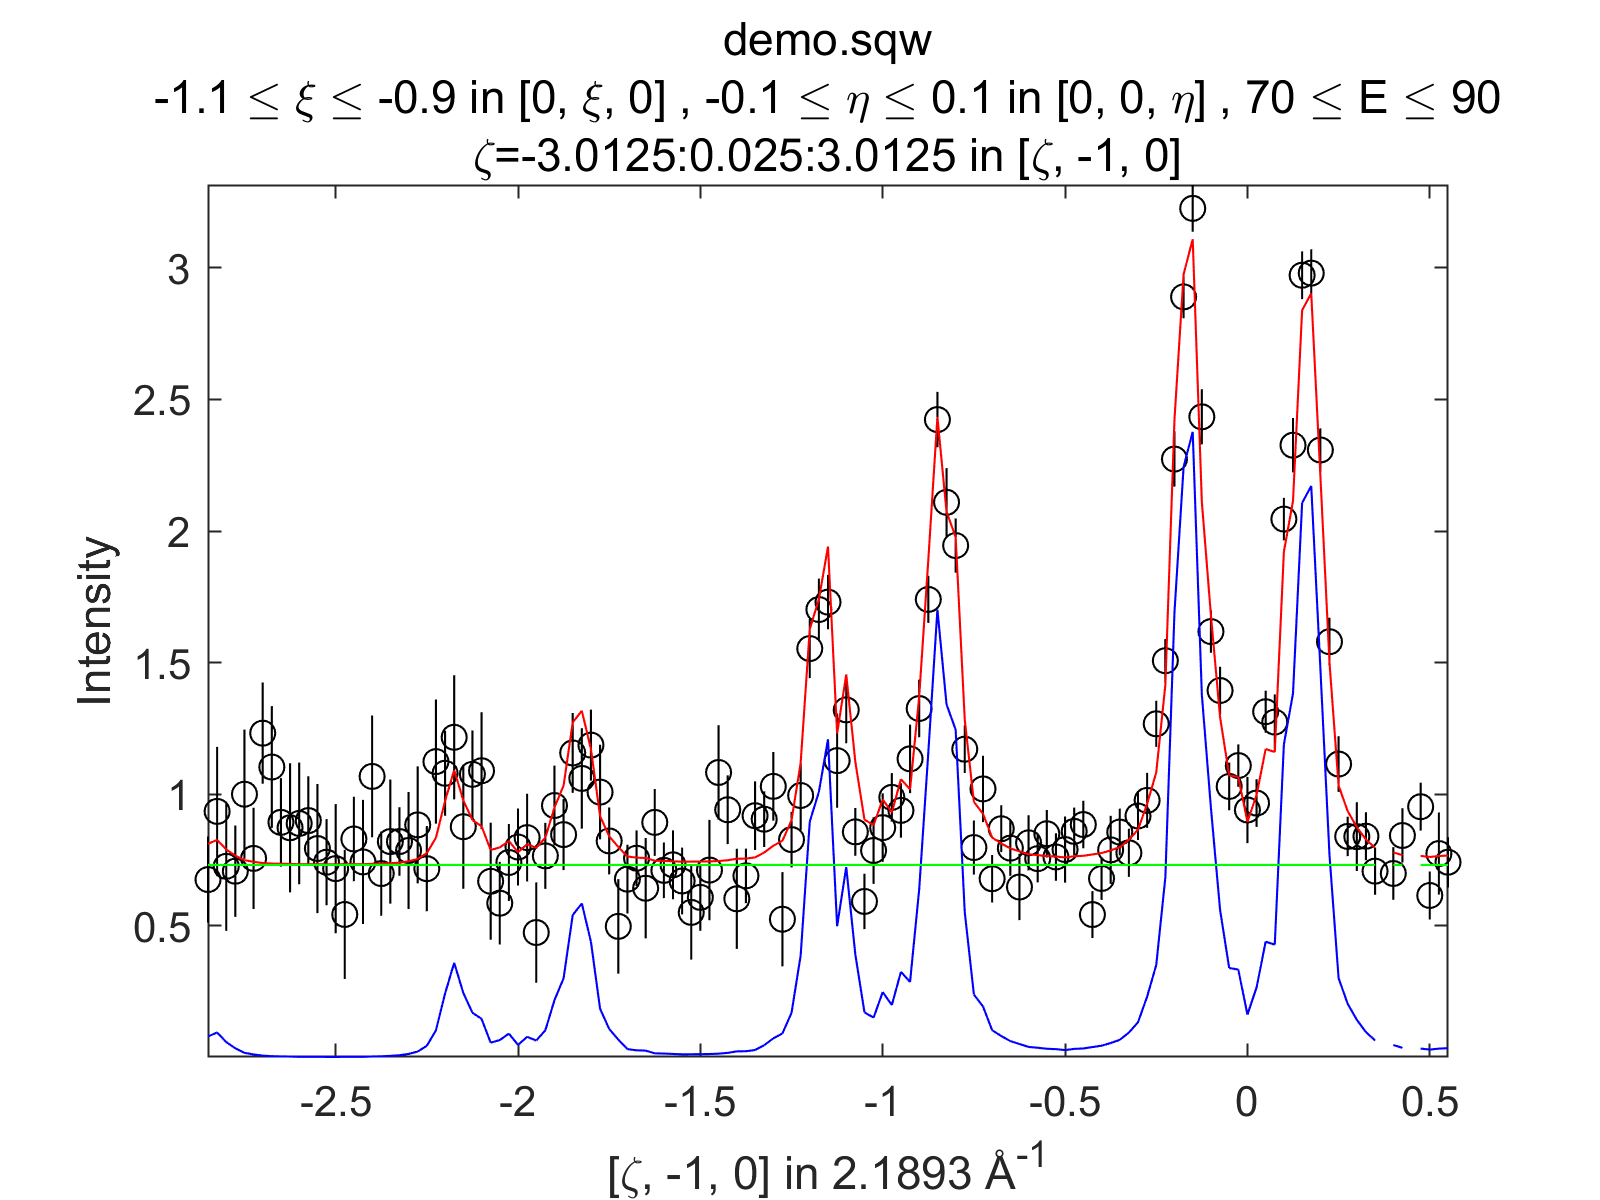

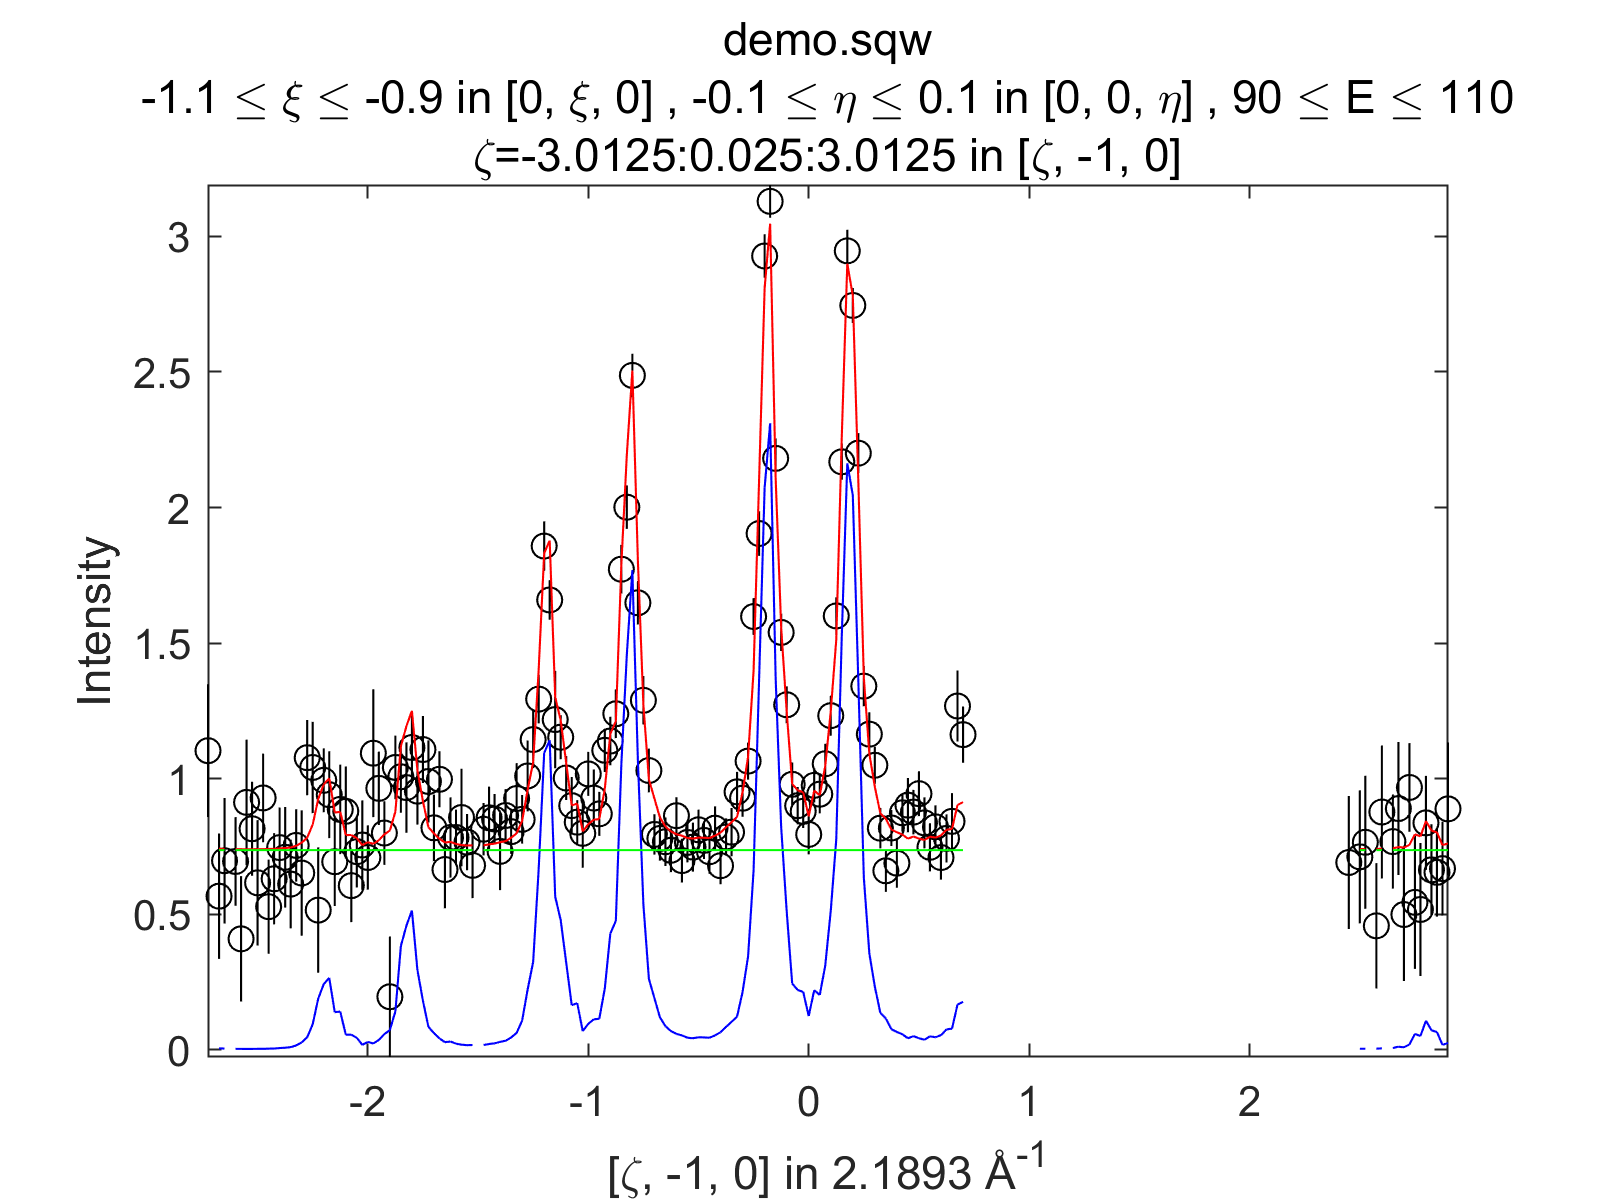

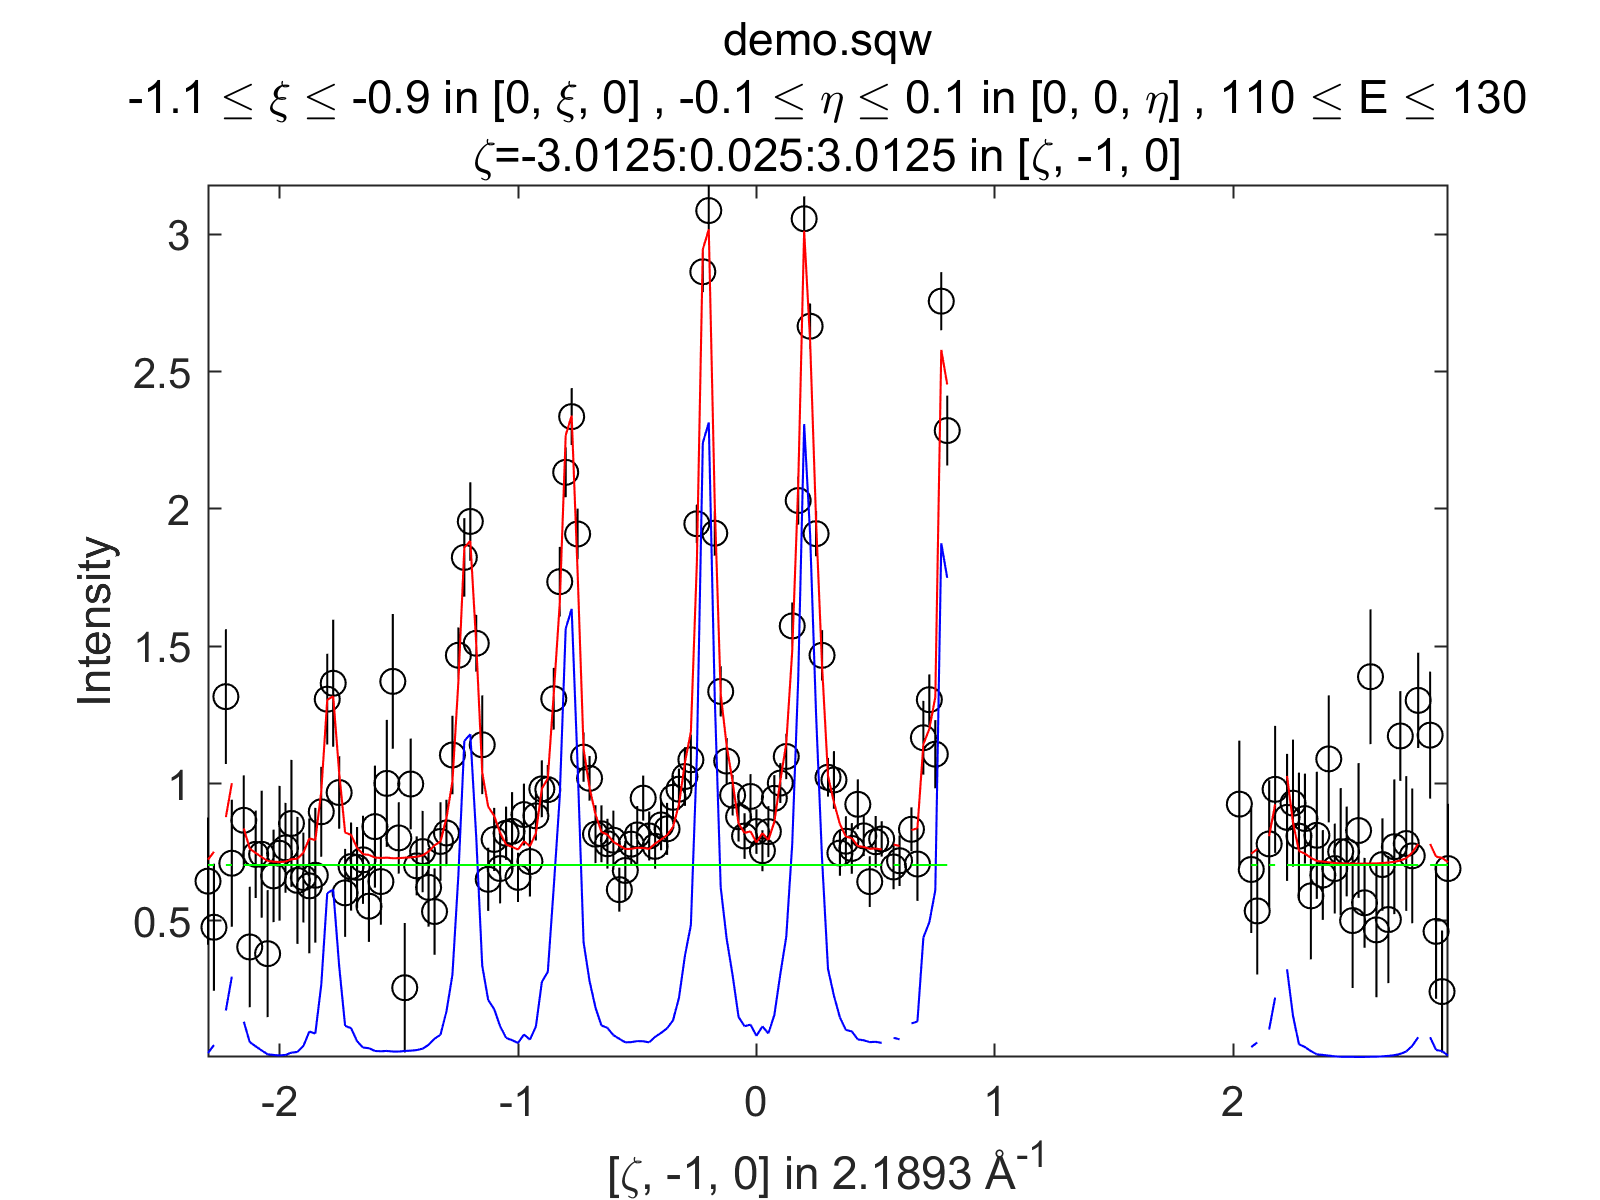

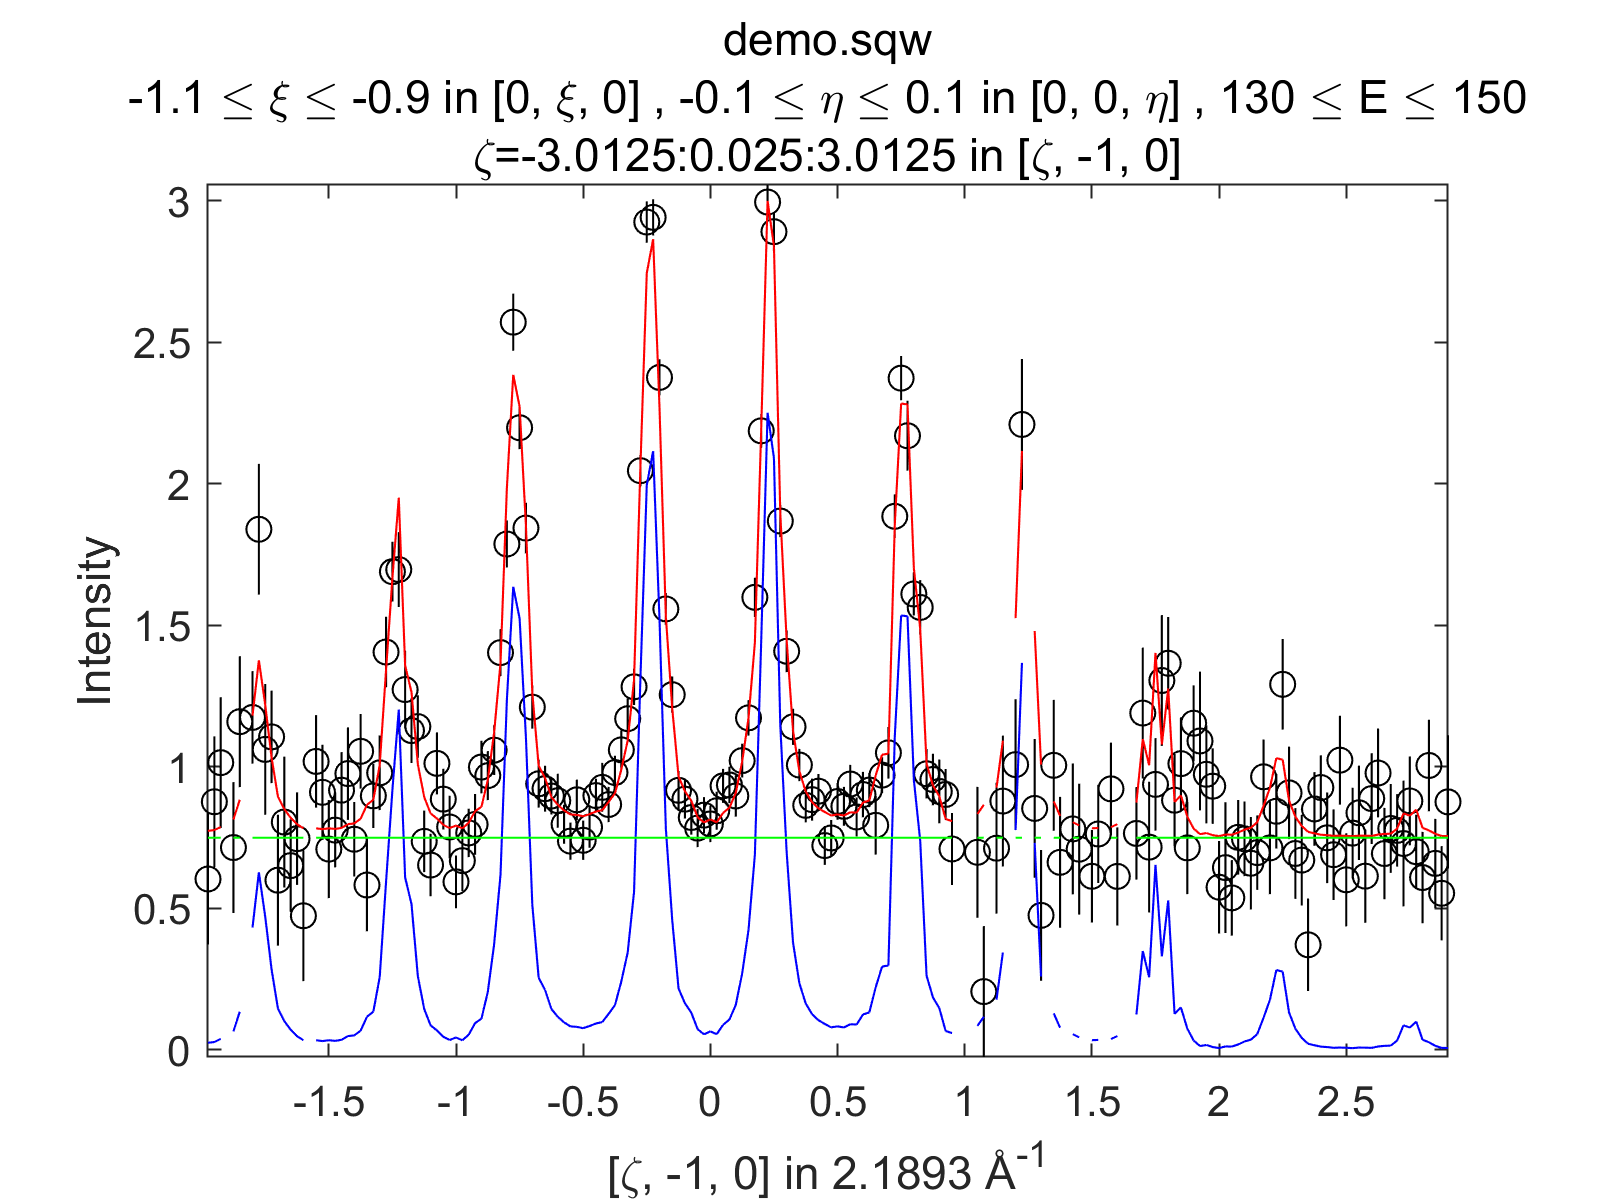

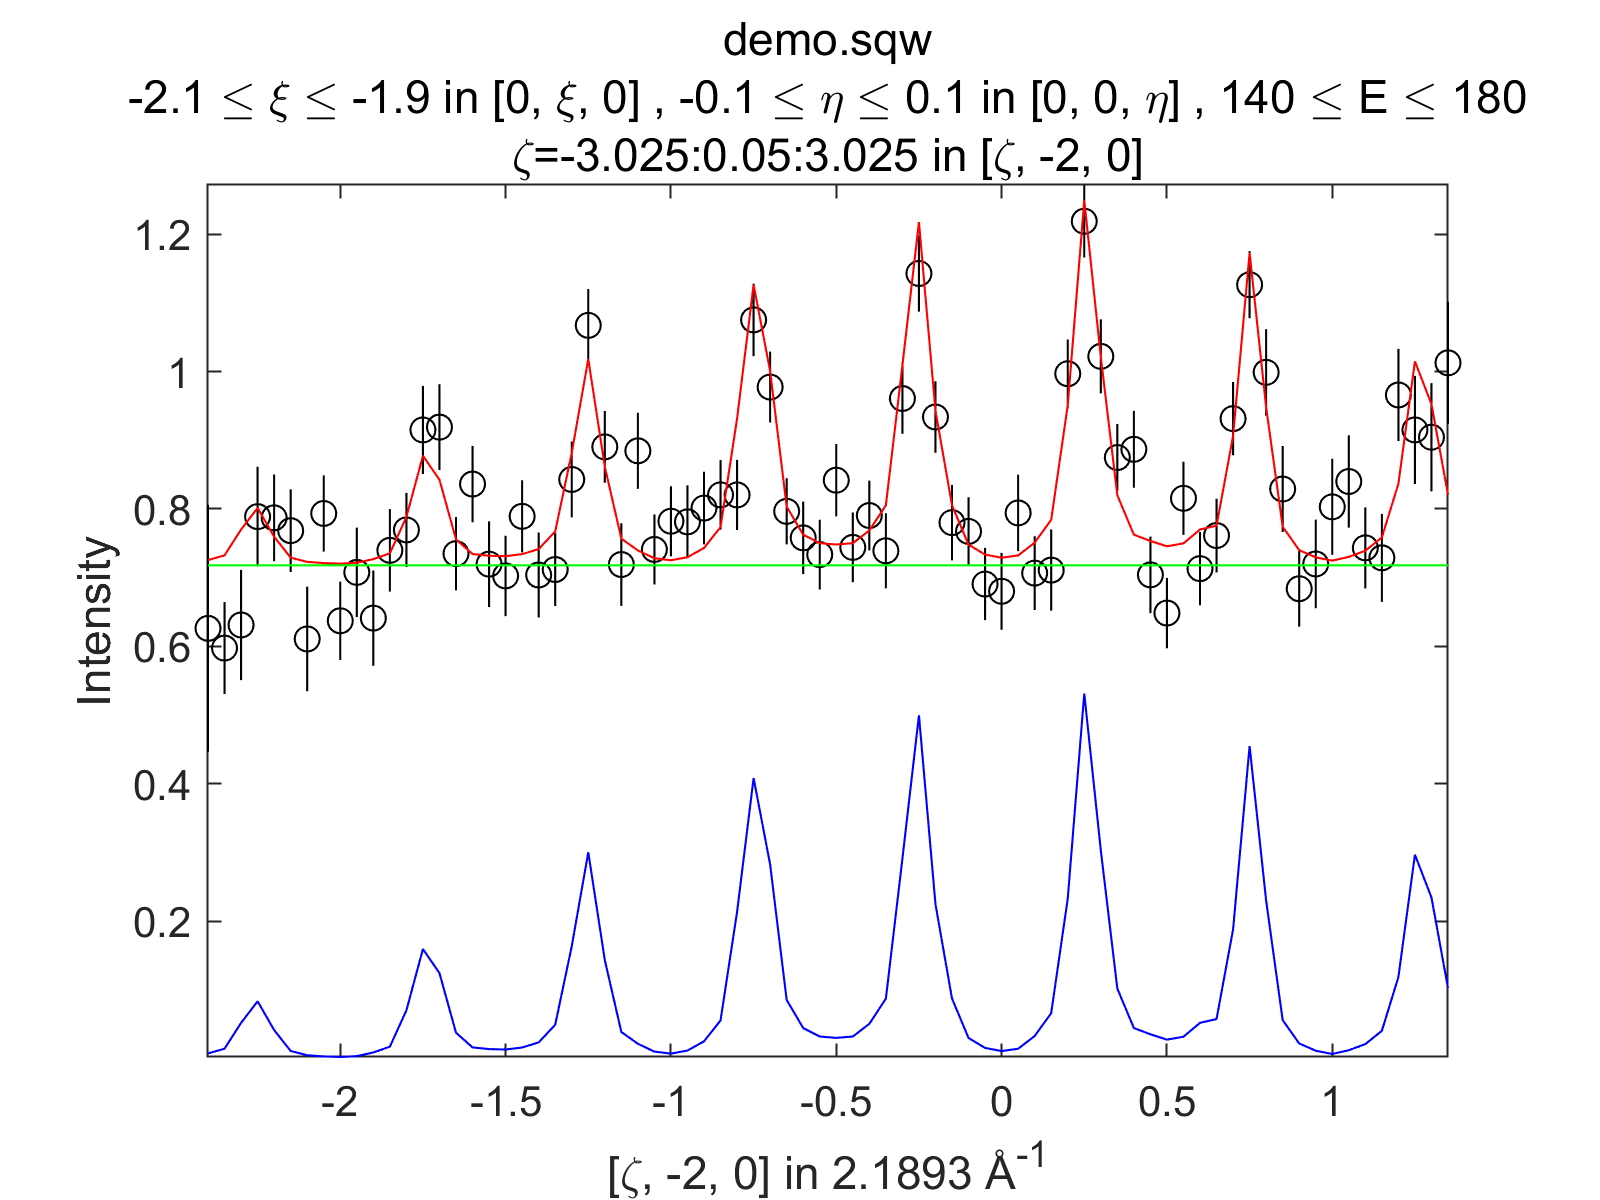

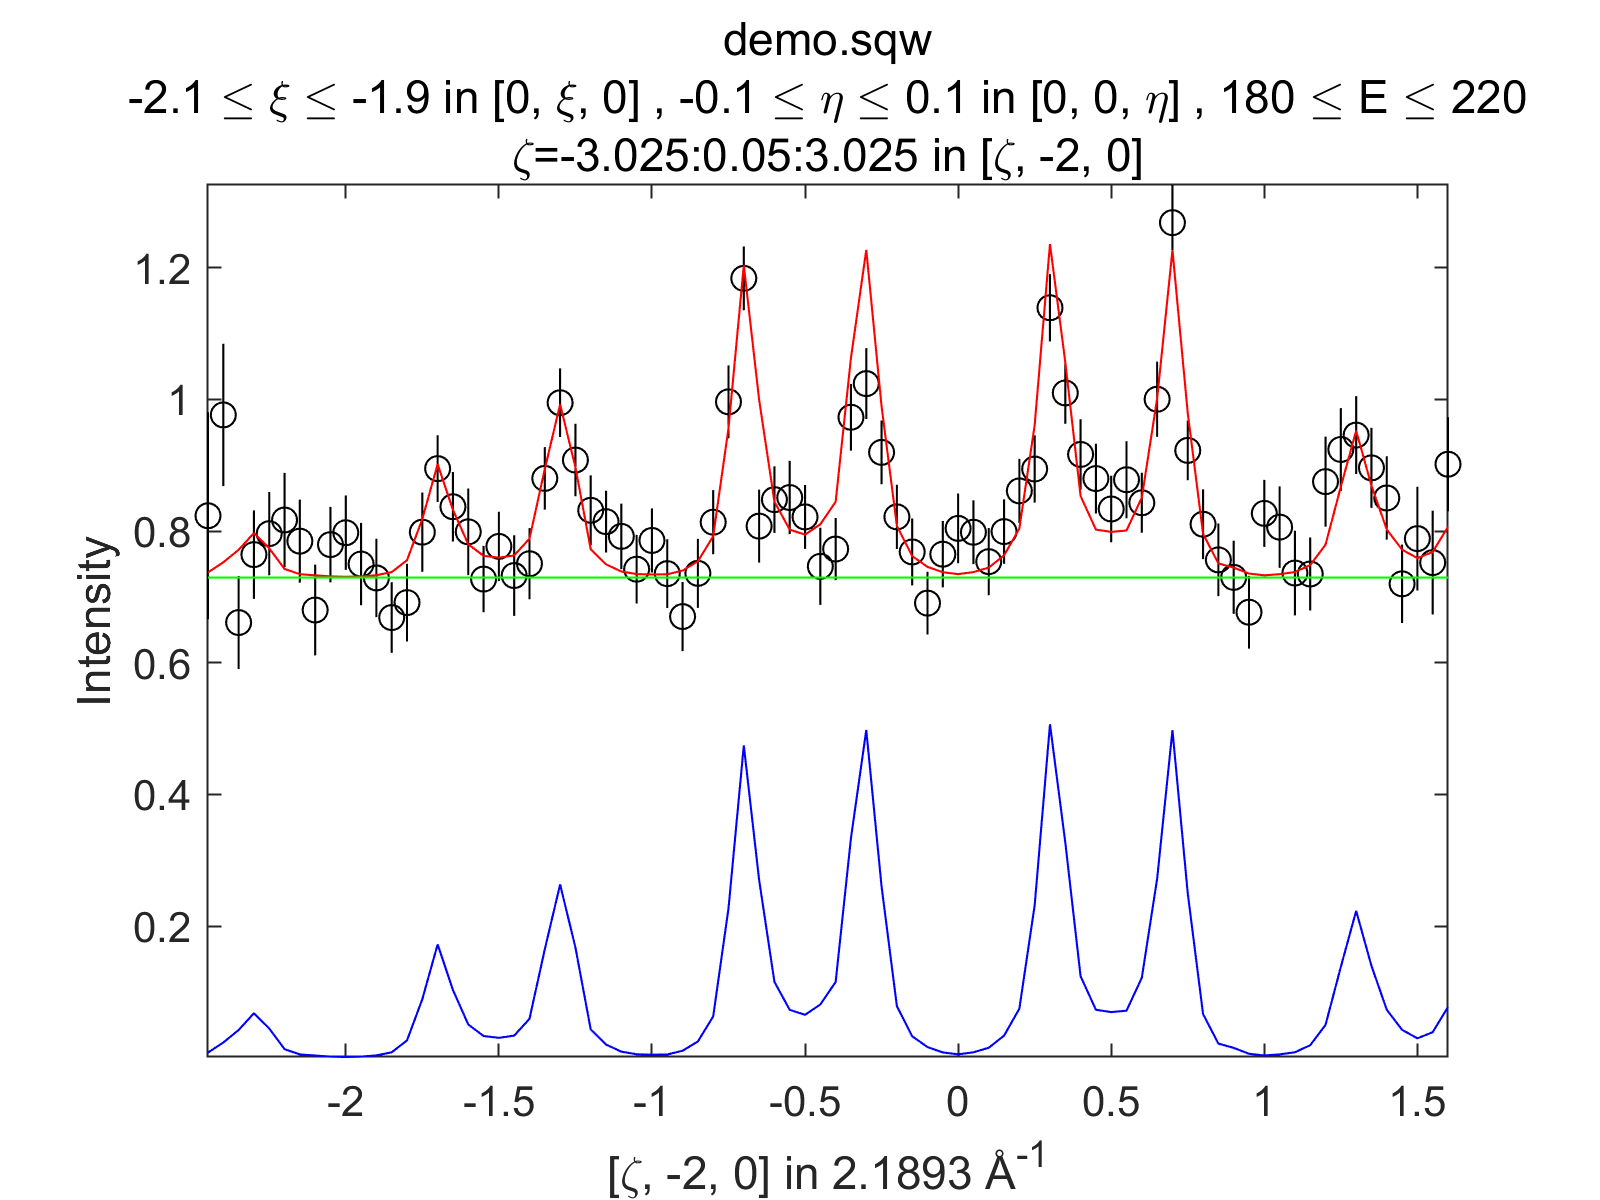

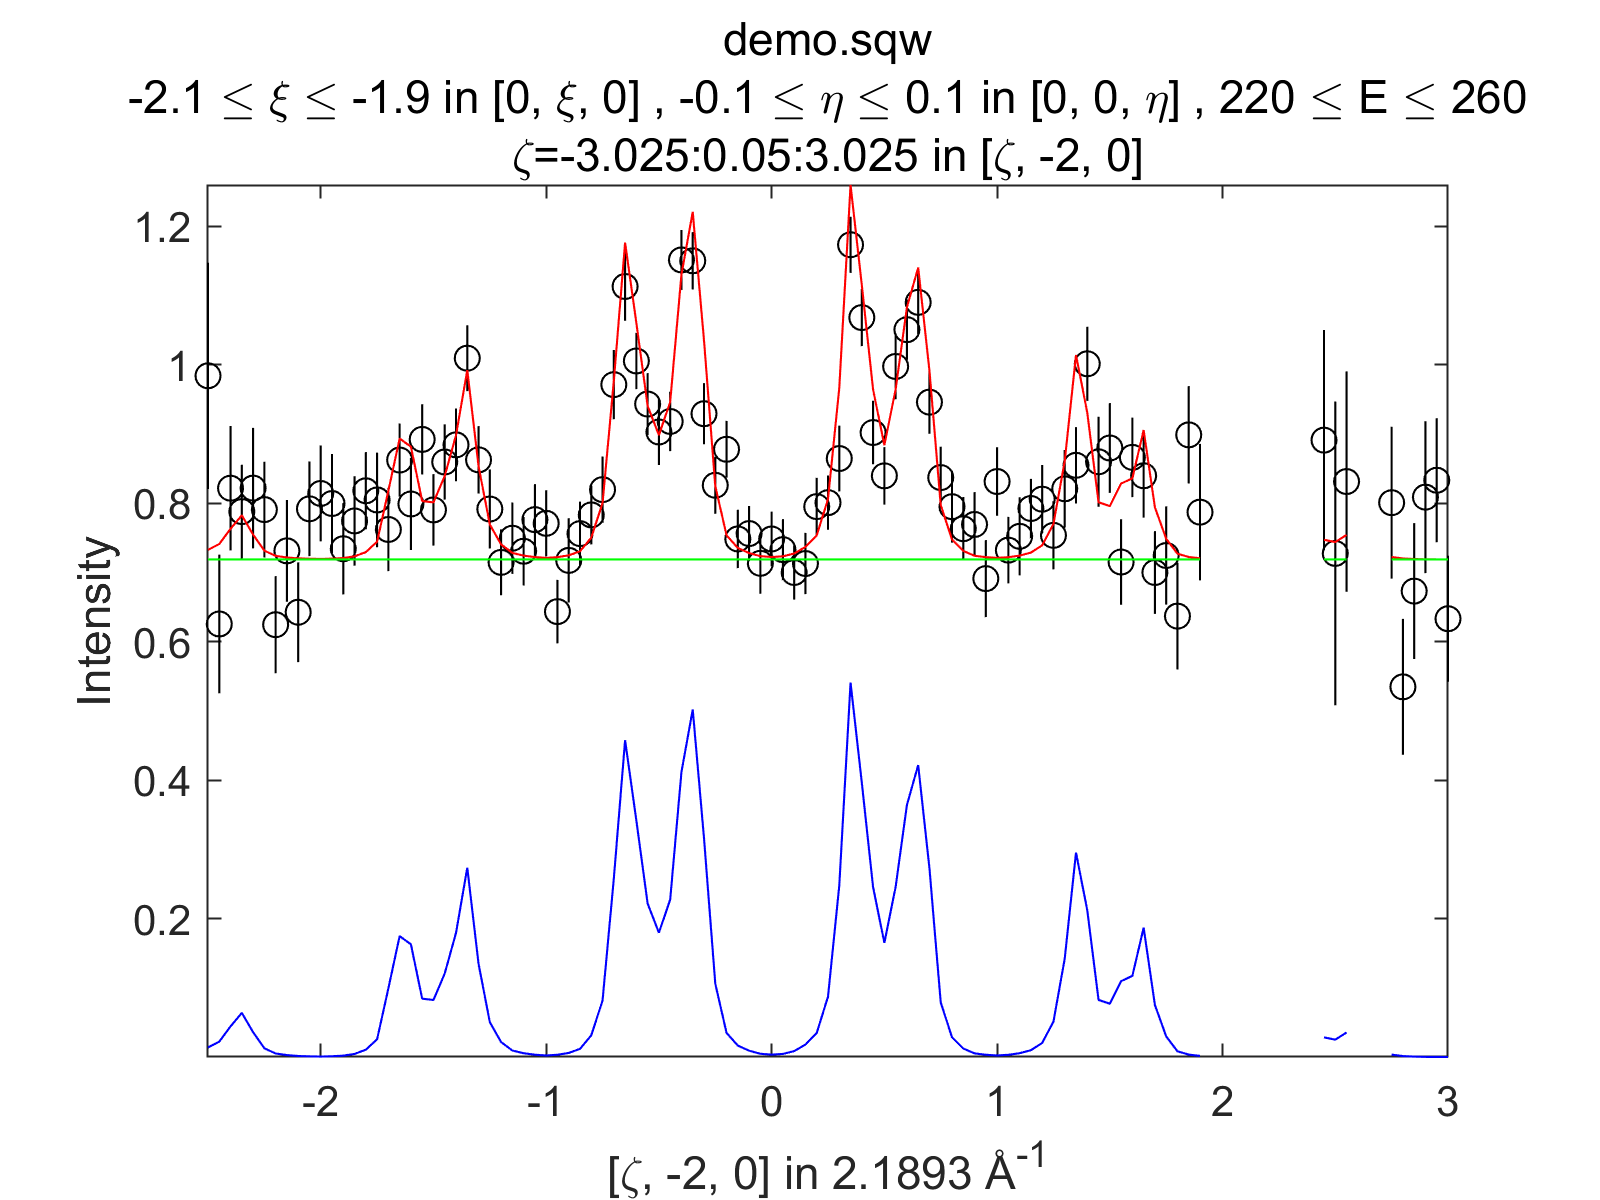

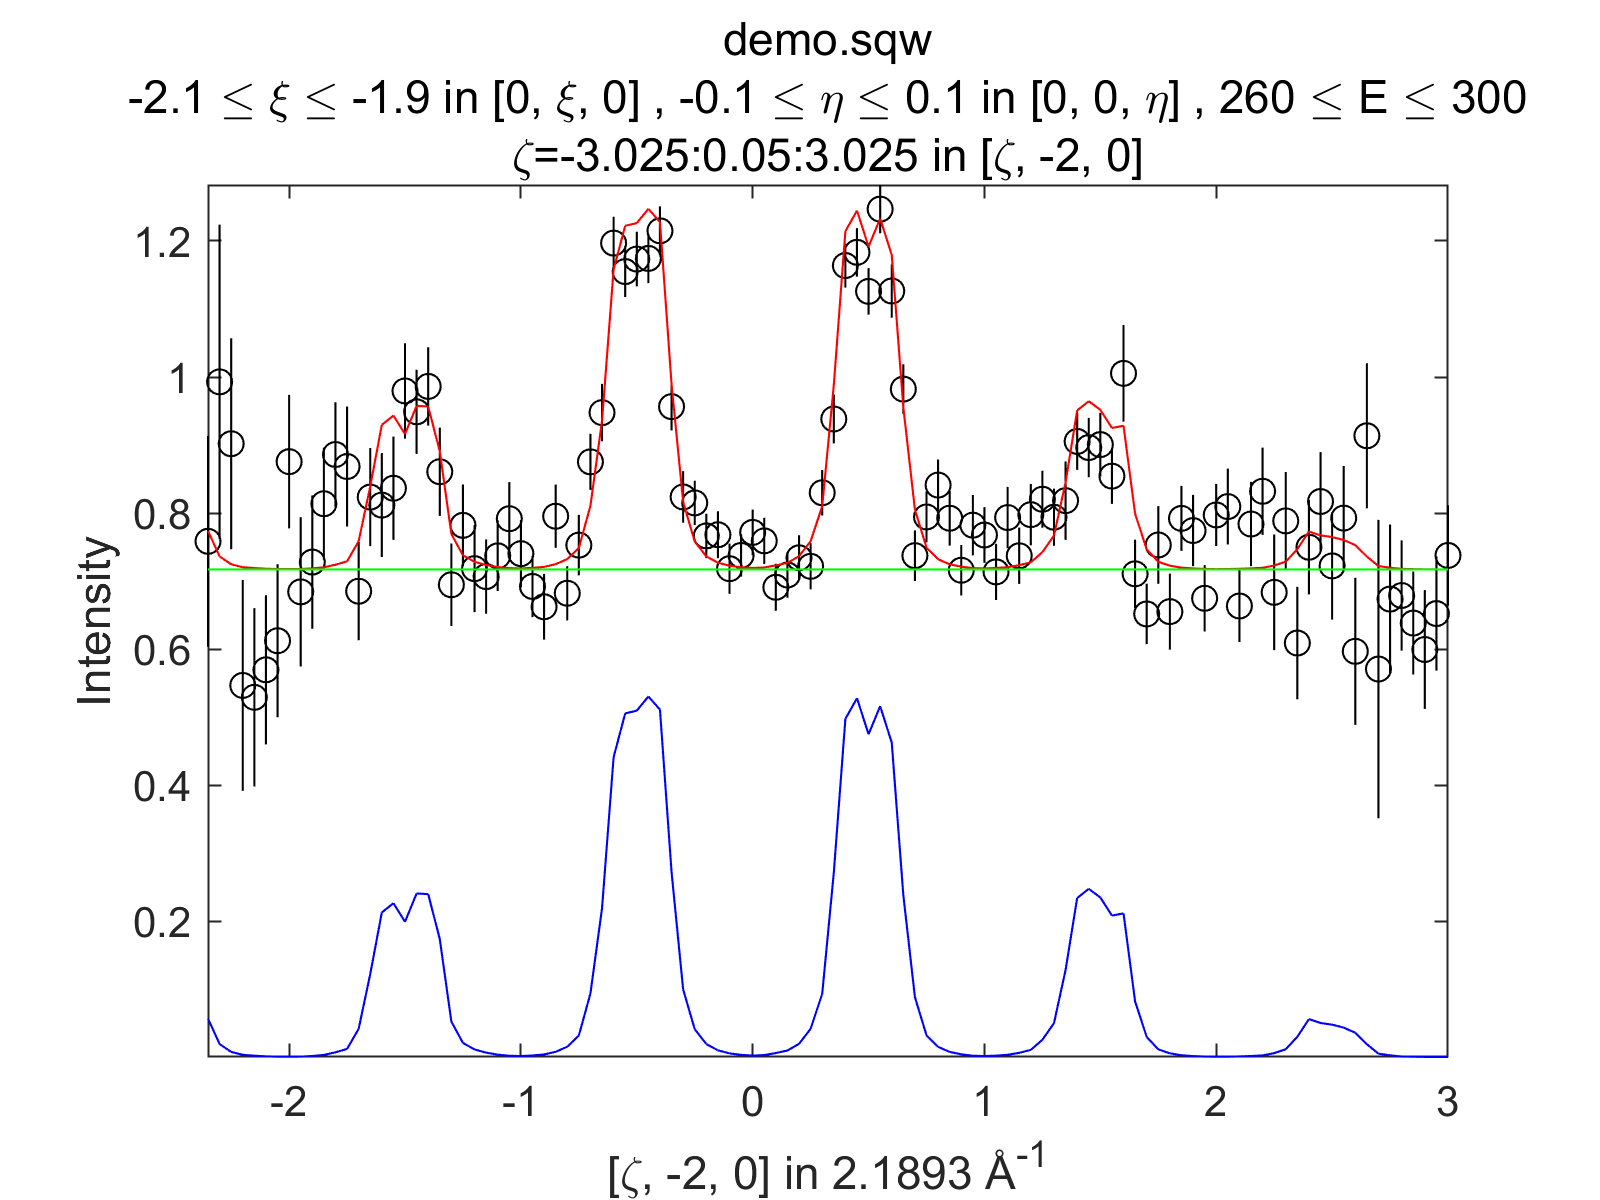

In [5]:
%matlab_fig -w 1600 -h 1200 
%matlab_plot_mode inline inline
index=0
for index in range(len(my_cuts)):
    m.acolor('k') #reset the color to black
    m.plot(my_cuts[index]) #plot the data
    m.acolor('r')
    m.pl(wfit['sum'][index]) #draw a red line with the total fit
    m.acolor('b')
    m.pl(wfit['fore'][index]) #draw a blue line with the foreground/model without background
    m.acolor('g')
    m.pl(wfit['back'][index]) #draw a green line with the background
    m.keep_figure()

m.acolor('k') #reset the color to black

And finally, let's look at the fit parameters. You might notice that the fitted exchange parameter, J, is very different from the previous tutorial. This is merely a matter of definitions: In the model used in the previous tutorial, the value of the spin was absorbed in J. Here, we set the spin on each site to be 5/2, and since the energy depends on the product SJ, the value of J goes down accordingly. We can compare the values 

In [6]:
def pretty_array(arr):
    return np.array2string(arr, precision=4, suppress_small=True)

print("Fit parameters (p):", pretty_array(fitdata['p']))
print("Standard deviations (sig):", pretty_array(fitdata['sig']))
print("Background parameter 0 (bp[0]):", pretty_array(fitdata['bp'][0]))
print("Background std dev 0 (bsig[0]):", pretty_array(fitdata['bsig'][0]))
print("Background parameter 1 (bp[1]):", pretty_array(fitdata['bp'][1]))
print("Background std dev 1 (bsig[1]):", pretty_array(fitdata['bsig'][1]))
print("Chi-squared (chisq):", pretty_array(fitdata['chisq']))

print("JS:", pretty_array(fitdata['p'][0][0]*5/2) + " meV")

Fit parameters (p): [[ 28.0162   0.      30.3365  10.     342.0371]]
Standard deviations (sig): [[0.0673 0.     0.486  0.     3.8047]]
Background parameter 0 (bp[0]): [[0.    0.722]]
Background std dev 0 (bsig[0]): [[0.     0.0105]]
Background parameter 1 (bp[1]): [[0.     0.7357]]
Background std dev 1 (bsig[1]): [[0.     0.0121]]
Chi-squared (chisq): [[1.1596]]
JS: 70.0404 meV
